In [1]:
import numpy as np
import scipy.special as sp
import scipy.interpolate as sp_i
import matplotlib.pyplot as plt

In [2]:
import sys
if "../src/" not in sys.path:
    sys.path.insert(0,"../src/")
from pbcpy.grid import DirectGrid, ReciprocalGrid
from pbcpy.field import DirectField, ReciprocalField
from pbcpy.functionals import *
from pbcpy.local_functionals_utils import x_TF_y_vW 
from pbcpy.nonlocal_functionals_utils import LindhardFunction, MGP_kernel, WT_kernel
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF

%matplotlib inline
%load_ext autoreload
%autoreload 2
#

In [3]:
mol = PP(filepp='Al_fde_rho.pp').read()

In [4]:
density_real_space = mol.field

# Local and Semilocal Functionals energy and potential

In [5]:
TFvW = x_TF_y_vW(density_real_space,x=1,y=1,Sigma=0.05)

# Nonlocal Functionals energy and potential

In [6]:
rho0=density_real_space.integral() / density_real_space.grid.volume
print(rho0)

0.0268476949077


In [7]:
rho0=np.real(density_real_space.fft()[0,0,0,0] / density_real_space.grid.volume)
print(rho0)

0.0268476949077


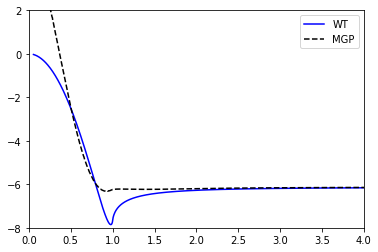

In [8]:
#
# Cute-looking kernels
#
q=np.linspace(0.1,8,1000)
gmpker = MGP_kernel(q,rho0,0.3,500)
wtker = WT_kernel(q,rho0)
eta = q/(2.0 * (3.0 * rho0 * np.pi**2)**(1.0/3.0))
plt.plot(eta,wtker,color='blue',label='WT')
plt.plot(eta,gmpker,label='MGP',color='black',linestyle='--')
plt.xlim(0,4)
plt.ylim(-8,2)
plt.legend()
#plt.savefig("./kernels_comparison.pdf")
plt.show()

In [9]:
def WT(density_real_space,rho_star=None):
    '''Wang-Teter nonlocal functional
    Input: density DirectField, rho_star (optional)
    Output: WT Functional class
    '''
    if rho_star is None:
        rho0=density_real_space.integral() / density_real_space.grid.volume
    else:
        rho0=rho_star

    q = np.sqrt(density_real_space.grid.get_reciprocal().gg)
    wtker = WT_kernel(q,rho0)
    rhofs = density_real_space**(5.0/6.0)
    rhofs_g = rhofs.fft()
    rhofs_kernel = wtker*rhofs_g
    WT_edens = rhofs_kernel.ifft(force_real=True)*rhofs 
    rhoos = density_real_space**(-1.0/6.0)
    WT_pot = (5.0/6.0)*2.0* rhoos * rhofs_kernel.ifft(force_real=True)
    WT_NL_Functional = Functional( name='WT',energydensity=WT_edens, potential=WT_pot,kernel=WT_kernel(q,rho0))
    
    return WT_NL_Functional.sum(x_TF_y_vW(x=1.0,y=1.0,rho=density_real_space,Sigma=0.15))

In [10]:
def WT_NL(density_real_space,rho_star=None):
    '''Wang-Teter nonlocal functional
    Input: density DirectField, rho_star (optional)
    Output: WT Functional class
    '''
    
    if rho_star is None:
        rho0=density_real_space.integral() / density_real_space.grid.volume
    else:
        rho0=rho_star
    print('rho0 in WT_NL = ', rho0)
    q = np.sqrt(density_real_space.grid.get_reciprocal().gg)
    wtker = WT_kernel(q,rho0)
    rhofs = density_real_space**(5.0/6.0)
    rhofs_g = rhofs.fft()
    rhofs_kernel = rhofs_g*wtker
    WT_edens = rhofs_kernel.ifft(force_real=True)*rhofs 
    rhoos = density_real_space**(-1.0/6.0)
    WT_pot = (5.0/6.0)*2.0* rhoos * rhofs_kernel.ifft(force_real=True)
    
    return Functional( name='WT',energydensity=WT_edens, potential=WT_pot,kernel=WT_kernel(q,rho0))

In [11]:
def ZeroFunctional(density):
    myzero = DirectField(grid=density.grid, griddata_3d=np.zeros(density.grid.nr))
    shape = density.grid.get_reciprocal().nr
    myzero_g = np.zeros(shape)
    return Functional(energydensity=myzero,potential=myzero,kernel=myzero_g)

In [13]:
if np.sum(np.abs(ZeroFunctional(density_real_space).energydensity)) < 1.0e-4:
    print('OK')

OK


In [14]:
WT = WT(density_real_space)

In [15]:
WT.energydensity.integral()*27.211385

79.31218782190335

# LDA versions

In [16]:
rho0=np.max(density_real_space) / density_real_space.grid.volume
lda = []
for i in range(10):
    lda.append(WT_NL(density_real_space,rho_star=rho0/np.float(i+1)))
lda.append(ZeroFunctional(density_real_space))

rho0 in WT_NL =  0.0009833737433567595
rho0 in WT_NL =  0.0004916868716783797
rho0 in WT_NL =  0.0003277912477855865
rho0 in WT_NL =  0.00024584343583918986
rho0 in WT_NL =  0.0001966747486713519
rho0 in WT_NL =  0.00016389562389279325
rho0 in WT_NL =  0.00014048196333667993
rho0 in WT_NL =  0.00012292171791959493
rho0 in WT_NL =  0.00010926374926186216
rho0 in WT_NL =  9.833737433567595e-05


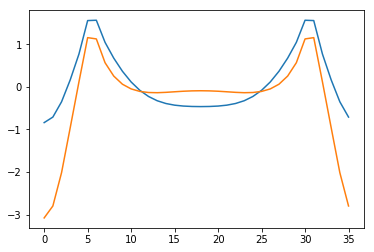

In [31]:
plt.plot((lda[0].potential[:,0,0,0]-lda[9].potential[:,0,0,0])*500)
plt.plot(lda[0].potential[:,0,0,0])
plt.show()

# decay of $v[\rho_0]$ as $\rho_0 \to 0$

In [19]:
a = []
for i in range(10):
    a.append((lda[i].potential*density_real_space.grid.r).integral())

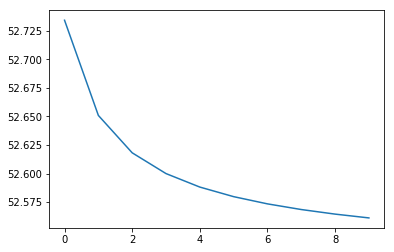

In [20]:
plt.plot(a)
plt.show()

# let's check if the decay is exponential

## first derivative

In [22]:
derivative = []
for i in range(9):
    derivative.append((lda[i+1].potential - lda[i].potential)*10.0/rho0)

In [23]:
second_derivative = []
for i in range(8):
    second_derivative.append((derivative[i+1]-derivative[i])*10.0/rho0)

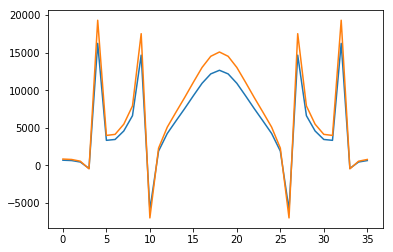

In [34]:
plt.plot(second_derivative[4][:,0,0,0]/lda[4].potential[:,0,0,0])
plt.plot(-3000*(derivative[4][:,0,0,0]/lda[4].potential[:,0,0,0]))
#plt.plot(derivative[4][:,0,0,0])
#plt.plot(second_derivative[4][:,0,0,0])
plt.show()

## indeed, it decays exponentially (first and second derivatives are related to the potential by a constant)

# evaluation of the asymptote as $\rho_0 \to 0$

In [36]:
alpha = - 2.0 * derivative[8] / (lda[8].potential + lda[9].potential)

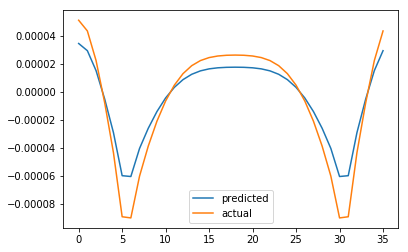

In [49]:
pot = lda[7].potential
pot2 = lda[6].potential
interp = lda[6].potential * np.exp(-alpha * (rho0/10.0))
plt.plot(interp[:,0,0,0]-pot2[:,0,0,0],label='predicted')
plt.plot(pot[:,0,0,0]-pot2[:,0,0,0],label='actual')
plt.legend()
plt.show()

### not perfect -- but pretty good!

In [52]:
def Get_N_WT(density,nrho):
#
#
    rho_max=np.max(density)
    rho_min=np.min(density)
#
#
    lda = []
    for i in range(nrho):
        rho0=rho_min + (rho_max-rho_min)/np.float(i+1)
        lda.append(WT_NL(density,rho_star=rho0))
#
#
    derivative = []
    for i in range(nrho-1):
        derivative.append((lda[i+1].potential - lda[i].potential)*np.float(nrho)/rho0)
        
    alpha = - 2.0 * derivative[nrho-3] / (lda[nrho-3].potential + lda[nrho-2].potential)
    return lda, alpha

In [ ]:
def NL_WTLDA(density):
    potential = density.copy()
    for i in range(density.grid.nr[0]):
        for j in range(density.grid.nr[1]):
            for k in range(density.grid.nr[2]):
                interp = sp_i.CubicSpline()
                potential[i,j,k,0] = 
    return potential